In [37]:
# Load the packages
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import precision_recall_curve, auc, f1_score
seed = 42
# Input data files are available in the "../input/" directory.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data = pd.read_csv(os.path.join(dirname, filename))

# Data exploration

In [3]:
# Get familiar with the column names
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
# Check data types
print(data.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [5]:
# Descriptive Statistics
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.23709

## What is the dimension of the dataset?
### We have 284807 transcations and 30 features with 1 being the output class

In [7]:
# Explore the number of rows and columns
data.shape # We have 284807 transcations and 30 features with 1 being the output class

(284807, 31)

## Are there any missing values?
### No missing values

In [8]:
# Check missing values
droppedna = data.dropna() # drop the rows that have at least one element missing
droppedna.shape # Verify the dimension of the data and it is the same as the original dimension

(284807, 31)

## What is the class distribution?
### The output are highly imbalanced. Class 1 (fraud cases) is only 0.17% of all the outputs

In [9]:
# class distribution at a glance
print(data.groupby(['Class']).size())
num_class0 = data.groupby(['Class']).size()[0]
num_class1 = data.groupby(['Class']).size()[1]
percentage = num_class1/(data.shape[0]) * 100
print("The percentage of class 1 in the entire dataset is: %5.5f" %  percentage) 

Class
0    284315
1       492
dtype: int64
The percentage of class 1 in the entire dataset is: 0.17275


## What is the distribution of the transaction time?
### It shows a bimodel distribution

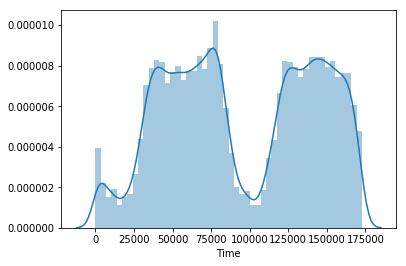

In [10]:
sns.distplot(data['Time'])

## What is the relationship between time and amount?
### We can see that the more transcaction records, the more it is likely to appear a higher amount.

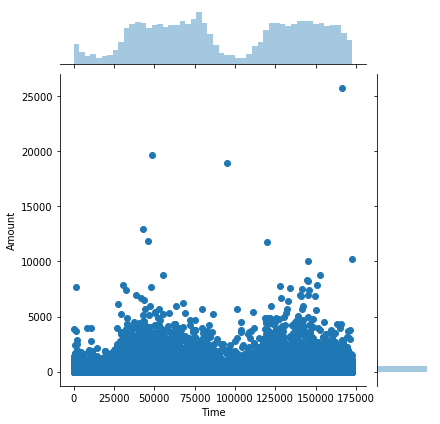

In [11]:
sns.jointplot(x="Time", y="Amount", data=data[["Time","Amount"]]);

## The distribution of the data

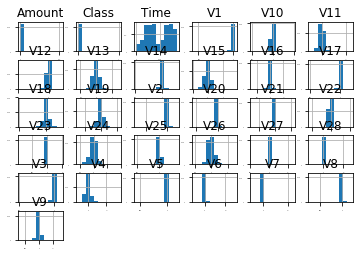

In [12]:
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

In [14]:
# Split training and testing dataset
X = data.drop(columns="Class")
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

## Neural Network

In [18]:
# Building a neural network model
def nn_model(trainX, trainY ,num_node=10, loss='binary_crossentropy', optimizer='adam'):
    # Define the model
    model = Sequential()
    # 5 hidden layers with 10 nodes by default with a ReLU activation function
    model.add(Dense(num_node, input_dim=trainX.shape[1], activation='relu'))
    model.add(Dense(num_node, activation='relu'))
    model.add(Dense(num_node, activation='relu'))
    model.add(Dense(num_node, activation='relu'))
    model.add(Dense(num_node, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])
    # Train the model
    model.fit(trainX, trainY, epochs=10, verbose=1)
    return model
    

## Evaluation metrics with precision and recall

In [19]:
def evaluate(y_test, y_pred):
    # precision true positive / (true positive + false positive)
    # recall: true positive  / (true positive + false ne)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # f1 = 2 * (precision * recall) / (precision + recall)
    f1 = f1_score(y_test, y_pred)
    #auc_score = auc(precision, recall)
    return precision, recall, f1

In [20]:
# Neural Network classification
nn = nn_model(X_train,y_train)

Epoch 1/10
227845/227845 [==============================] - 12s 55us/step - loss: 89.9661 - acc: 0.9773
Epoch 2/10
227845/227845 [==============================] - 12s 53us/step - loss: 0.2131 - acc: 0.9981
Epoch 3/10
227845/227845 [==============================] - 12s 53us/step - loss: 0.0958 - acc: 0.9979
Epoch 4/10
227845/227845 [==============================] - 12s 53us/step - loss: 0.0139 - acc: 0.9983
Epoch 5/10
227845/227845 [==============================] - 12s 52us/step - loss: 0.0129 - acc: 0.9983
Epoch 6/10
227845/227845 [==============================] - 12s 53us/step - loss: 0.0331 - acc: 0.9979
Epoch 7/10
227845/227845 [==============================] - 12s 53us/step - loss: 0.0152 - acc: 0.9983
Epoch 8/10
227845/227845 [==============================] - 12s 52us/step - loss: 0.0142 - acc: 0.9983
Epoch 9/10
227845/227845 [==============================] - 12s 55us/step - loss: 0.0178 - acc: 0.9983
Epoch 10/10
227845/227845 [==============================] - 12s 53us/st

In [21]:
# Make prediction
nn_pred = nn.predict_classes(X_test)
nn_precision, nn_recall, nn_f1 = evaluate(y_test,nn_pred)
print(nn_precision)
print(nn_recall)

[0.00172045 1.        ]
[1. 0.]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Include other classic classification algorithms
* Linear Algorithms: Linear Algorithms: Logistic Regression (LR),  Linear Discriminant Analysis (LDA), SGDClassifier (SGDC), Linear Support Vector Machines (Linear SVC)
* Nonlinear Algorithms: Classification and Regression Trees (CART), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

In [26]:
# Test on more algorithms
models = []
models.append(('LR' , LogisticRegression(random_state = seed))) # Specify 'sag' for a faster performance to deal with large dataset.
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier(random_state = seed)))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , LinearSVC(random_state = seed)))
models.append(('SGDC', SGDClassifier()))
# evaluate each model in turn
results = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f1 = evaluate(y_test,y_pred)
    results.append((name, precision, recall, f1))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Comparison among all algorithms in terms of AUPRC

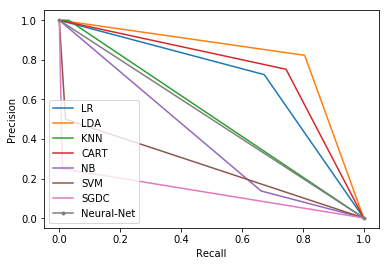

In [27]:
# plot the precision-recall curves
#no_skill = len(y_test[y_test==1]) / len(y_test)
#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
for name, precision, recall, f1 in results:
    plt.plot(recall, precision, label=name)
plt.plot(nn_recall, nn_precision, marker='.', label='Neural-Net')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Will standardization improve the algorithm performance?
### Yes, KNN has greatly improved its performance based the area under precision and recall curve. 

In [30]:
# Tried standardizing the data to see if there is a performance gain.
std_models = []
std_models.append(('ScaledLR', Pipeline([('Scaler' , StandardScaler()),( 'LR',
LogisticRegression(random_state = seed))]))) 
std_models.append(('ScaledLDA', Pipeline([('Scaler' , StandardScaler()),('LDA',
LinearDiscriminantAnalysis())])))
std_models.append(('ScaledKNN', Pipeline([('Scaler' , StandardScaler()),('KNN',
KNeighborsClassifier())])))
std_models.append(('ScaledCART', Pipeline([('Scaler' , StandardScaler()),('CART',
DecisionTreeClassifier(random_state = seed))])))
std_models.append(('ScaledNB' , Pipeline([('Scaler' , StandardScaler()),('NB',
GaussianNB())])))
std_models.append(('ScaledSVM' , Pipeline([('Scaler' , StandardScaler()),('SVM',
LinearSVC(random_state = seed))])))
std_models.append(('ScaledSGDC', Pipeline([('Scaler' , StandardScaler()),('SVM',
SGDClassifier())])))
# evaluate each model in turn
std_results = []
for name, model in std_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f1 = evaluate(y_test,y_pred)
    std_results.append((name, precision, recall, f1))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Train neural network on standardized data
scaler = StandardScaler().fit(X_train) # instantiate a scaler
scaledX_train = scaler.transform(X_train) # standardize the training data
std_nn = nn_model(scaledX_train, y_train)

In [34]:
# Make prediction on standardized data
std_nn_pred = std_nn.predict_classes(X_test)
std_nn_precision, std_nn_recall, std_nn_f1 = evaluate(y_test,std_nn_pred)
print(std_nn_precision)
print(std_nn_recall)

[0.00172045 1.        ]
[1. 0.]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


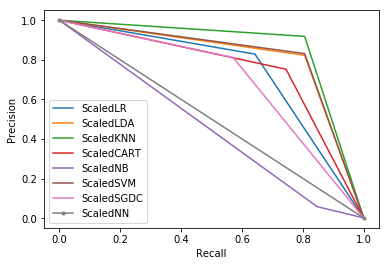

In [35]:
# plot the precision-recall curves
for name, precision, recall, f1 in std_results:
    plt.plot(recall, precision, label=name)
plt.plot(std_nn_recall, std_nn_precision, marker='.', label='ScaledNN')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Algorithm Tuning for KNN

In [39]:
# Tuning scaled KNN
n_neighbors = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29] # default is 5
param_grid = dict(n_neighbors=n_neighbors)
scoring = 'f1' # We use f1 to be our scoring metrics as it is a measure of how well our model performs based on the precision and recall
knn = KNeighborsClassifier()
grid = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = scoring) # Note the gridsearchCV will use 5-fold CV by default


In [ ]:
# Fit the model with standardized data
grid_result = grid.fit(scaledX_train, y_train)
print("The best F1 score is: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
# Get the mean f1 scores and its standard deviation from each parameters we have tested
mean_f1_score = grid_result.cv_results_['mean_test_score']
std_f1_score = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean_f1, std_f1, param in zip(mean_f1_score, std_f1_score, params):
print("%f (%f) with: %r" % (mean_f1, std_f1, param))